<center><h1>Store Sales - Time Series Forecasting</h1></center>

<p>Welcome to my data science project, which is focused on store sales time series forecasting. The project was initiated by Kaggle, a popular platform for data science competitions and challenges. The objective of this project was to develop a model that can accurately predict the future sales of a store using historical sales data.</p>
<p>In this project, I have utilized my skills in data visualization, data analytics, data cleansing, and machine learning to analyze the dataset and develop a predictive model. The dataset was obtained from the Kaggle competition website (https://www.kaggle.com/competitions/store-sales-time-series-forecasting), which contained information on the sales of a store for a period of two years.</p>

<h3>Data Exploratory</h3>
<p>First of all, I imported some essential Python libraries for the further task, data analysis.</p>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(np.__version__)
print(pd.__version__)
print(mpl.__version__)
print(sns.__version__)

1.24.2
1.5.3
3.7.0
0.12.2


<p>Then, I opened the first dataset from a CSV file named "stores" and stored the data in the form of Pandas' DataFrame named "df_store". This pattern of the dataset loading process also applies with other datasets to be analyzed, as you will see in the next cells.</p>

In [2]:
file_path = 'datasets'
df_store = pd.read_csv(os.path.join(file_path, 'stores.csv'))

df_store.head(5)

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [3]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


<p>The data in "df_store" is ready to be used since there are no null values. Let's move on to a new dataset named "df_oil", which is loaded from "oil.csv".</p>

In [4]:
# df_oil = pd.read_csv(os.path.join(file_path, 'oil.csv'))

# df_oil.head(5)

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [5]:
# df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


<p>Then, I needed to make sure that there were no missing days within the interval provided in "df_oil", so I split "date" into three columns, "day", "month", and "year", so that I could manipulate the datetime data easily in long term.</p>

In [6]:
def split_date(df, drop_date=True):
  df['day'] = df['date'].apply(lambda date: int(date.split('-')[2]))
  df['month'] = df['date'].apply(lambda date: int(date.split('-')[1]))
  df['year'] = df['date'].apply(lambda date: int(date.split('-')[0]))
  if drop_date:
    df.drop('date', axis=1, inplace=True)
    df = df[['day', 'month', 'year'] + list(df.columns[:-3])]
  return df

# df_oil = split_date(df_oil, drop_date=False)

# df_oil.head(5)

date  dcoilwtico  day  month  year
0  2013-01-01         NaN    1      1  2013
1  2013-01-02       93.14    2      1  2013
2  2013-01-03       92.97    3      1  2013
3  2013-01-04       93.12    4      1  2013
4  2013-01-07       93.20    7      1  2013

<p>Let's see what is the last date noted in the dataset.</p>

In [7]:
# df_oil.loc[len(df_oil.index) - 1]

date          2017-08-31
dcoilwtico         47.26
day                   31
month                  8
year                2017
Name: 1217, dtype: object

<p>After knowing that the last date in the dataset is 31st, August, 2017, I listed all years in the dataset to check whether there was any missing years.</p>

In [8]:
# df_oil_years = df_oil['year'].unique()

# df_oil_years

array([2013, 2014, 2015, 2016, 2017], dtype=int64)

<p>There are no missing years, I, then, checked for leap years in the interval. Leap years are years of which there are 29 days in February. To get the complete date, checking leap year cannot be avoided.</p>

In [9]:
# def is_leap_year(year):
#   if year % 4:
#     return False
#   else:
#     if year % 100:
#       return True
#     else:
#       if year % 400:
#         return False
#       else:
#         return True

# list(map(is_leap_year, list(map(int, list(df_oil_years)))))

[False, False, False, True, False]

<p>2016 is a leap year, so if "df_oil" is complete, there must be a record on 29th, February, 2016.</p>

In [10]:
# df_oil[(df_oil['day'] == 29) & (df_oil['month'] == 2) & (df_oil['year'] == 2016)]

date  dcoilwtico  day  month  year
824  2016-02-29       32.74   29      2  2016

<p>There is the record I was looking for, so I didn't have to fill any missing dates caused by the leap years rule. The next thing I did was filling some missing dates using the loop to check if there didn't exist the date.</p>

In [11]:
# days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# for year in df_oil_years:

#   if year == 2017:
#     final_month = 8
#   else:
#     final_month = 12

#   for month in range(1, final_month + 1):
#     for day in range(1, days_in_month[month - 1] + 1):
#       if len(df_oil[(df_oil['day'] == day) & (df_oil['month'] == month) & (df_oil['year'] == year)].index) == 0:

#         day_string = str(day)
#         month_string = str(month)
#         year_string = str(year)

#         if day < 10:
#           day_string = '0' + day_string
#         if month < 10:
#           month_string = '0' + month_string

#         df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)

# df_oil.info()

C:\Users\User\AppData\Local\Temp\ipykernel_26300\3552635643.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\3552635643.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\3552635643.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1704 non-null   object 
 1   dcoilwtico  1175 non-null   float64
 2   day         1704 non-null   int64  
 3   month       1704 non-null   int64  
 4   year        1704 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 66.7+ KB


C:\Users\User\AppData\Local\Temp\ipykernel_26300\3552635643.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\3552635643.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', np.nan, day, month, year]], columns=df_oil.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\3552635643.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_oil = df_oil.append(pd.DataFrame([[f'{year_string}-{month

<p>There are 1,704 rows in the dataset. To make sure there's no missing dates anymore, I manually calculated days in the interval as appeared in the dataset. There are 4 full years, 2013-2016, so there must be (365 * 4) + 1 days, which is 1,461 days. (I added 1 into the result because 2016 is a leap year, so we have to add one more day, 29th, February.) There are 8 full months in 2017 that were saved in the dataset, so there are 31 + 28 + 31 + 30 + 31 + 30 + 31 + 31 days, which is 243 days. Therefore, the number of total dates is 1,461 + 243 days, which is 1,704 days, and it's equal to the number of rows. Hence, "df_oil" has complete dates now.</p>
<p>For the dataset to be good for the visualization step, I sorted the rows by "year", "month", and "day", respectively, in ascending order.</p>

In [12]:
# df_oil = df_oil.sort_values(by=['year', 'month', 'day']).reset_index().drop('index', axis=1)

# df_oil.head(5)

date  dcoilwtico  day  month  year
0  2013-01-01         NaN    1      1  2013
1  2013-01-02       93.14    2      1  2013
2  2013-01-03       92.97    3      1  2013
3  2013-01-04       93.12    4      1  2013
4  2013-01-05         NaN    5      1  2013

<p>The final thing to complete the whole dataset was to fill null values in "dcoilwtico". Thus, in this case, I filled the value by months. The filled price is the average oil price of the month where the row that has the null value is located. For example, as we can see from the dataset head above, the oil price on 1st, January, 2013, was null, so the filled value is the average oil price in January, 2013.</p>

In [13]:
# for i in df_oil[df_oil['dcoilwtico'].isnull()].index:
#   df_oil.at[i, 'dcoilwtico'] = df_oil[(df_oil['month'] == df_oil.loc[i]['month']) & (df_oil['year'] == df_oil.loc[i]['year']) & (df_oil['dcoilwtico'].notnull())]['dcoilwtico'].mean()

# df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1704 non-null   object 
 1   dcoilwtico  1704 non-null   float64
 2   day         1704 non-null   int64  
 3   month       1704 non-null   int64  
 4   year        1704 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 66.7+ KB


<p>There are no null values anymore in "df_oil", so I saved the current dataset in a new CSV file named "oil_clean.csv" so that I wouldn't waste my time polishing the same old dataset next time.</p>

In [16]:
# df_oil.to_csv(os.path.join(file_path, 'oil_clean.csv'), index=False)

In [17]:
df_oil = pd.read_csv(os.path.join(file_path, 'oil_clean.csv'))

df_oil.head(5)

date  dcoilwtico  day  month  year
0  2013-01-01   94.756667    1      1  2013
1  2013-01-02   93.140000    2      1  2013
2  2013-01-03   92.970000    3      1  2013
3  2013-01-04   93.120000    4      1  2013
4  2013-01-05   94.756667    5      1  2013

In [18]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1704 non-null   object 
 1   dcoilwtico  1704 non-null   float64
 2   day         1704 non-null   int64  
 3   month       1704 non-null   int64  
 4   year        1704 non-null   int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 66.7+ KB


 <p>Let's move on to another dataset named "df_holiday", which was loaded from "holidays_events.csv".</p>

In [19]:
df_holiday = pd.read_csv(os.path.join(file_path, 'holidays_events.csv'))

df_holiday.head(5)

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [20]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


<p>I relied on this dataset, so I took that there was no missing holidays in "df_holiday". As a result, the dataset is complete, so we can explore more datasets. In this case, I continued by exploring "df_transactions", which was loaded from "transactions.csv".</p>

In [21]:
# df_transactions = pd.read_csv(os.path.join(file_path, 'transactions.csv'))

# df_transactions.head(5)

date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922

In [22]:
# df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


<p>First of all, I split the date into 3 columns, "day", "month", and "year", again in order to easily access each row in the future.</p>

In [23]:
# df_transactions = split_date(df_transactions, drop_date=False)

# df_transactions.head(5)

date  store_nbr  transactions  day  month  year
0  2013-01-01         25           770    1      1  2013
1  2013-01-02          1          2111    2      1  2013
2  2013-01-02          2          2358    2      1  2013
3  2013-01-02          3          3487    2      1  2013
4  2013-01-02          4          1922    2      1  2013

<p>Transaction data should contain transactions in the complete time interval. If we take the complete interval to be the same one in "df_oil", we'll see that the complete date interval is from 1st, January, 2013, to 31st, August, 2017. Besides, every store's transaction is supposed to be collected everyday, and it means there should exist all existing values of "store_nbr", 1-54, on each day. Therefore, we should make the dataset complete in terms of time interval and the number of stores on each day.</p>
<p>The first step of this approach is similar to the one I did to "df_oil", which is finding the missing data on 29th, February, 2016, as I recalled from "df_oil" that 2016 is a leap year, so 29th, February, 2016, should exist in "df_transactions" as well. Otherwise, the rows with null "transactions" value was filled.</p>

In [24]:
# def get_missing_store_nbrs():
#     return set(range(1, 55)).difference(df_transactions[(df_transactions['day'] == 29) & (df_transactions['month'] == 2) & (df_transactions['year'] == 2016)]['store_nbr'].values)

# get_missing_store_nbrs()

{52}

In [25]:
# df_transactions = df_transactions.append(pd.DataFrame([['2016-02-29', 52, np.nan, 29, 2, 2016]], columns=df_transactions.columns, index=[0]), ignore_index=True)

# get_missing_store_nbrs()

C:\Users\User\AppData\Local\Temp\ipykernel_26300\4287721244.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_transactions = df_transactions.append(pd.DataFrame([['2016-02-29', 52, np.nan, 29, 2, 2016]], columns=df_transactions.columns, index=[0]), ignore_index=True)


set()

<p>After the data on the special day in the leap year had been completely filled, the missing days and "store_nbr"s on each day were filled next.</p>

In [26]:
# days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# for year in range(2013, 2018):

#   if year == 2017:
#     final_month = 8
#   else:
#     final_month = 12

#   for month in range(1, final_month + 1):
#     for day in range(1, days_in_month[month - 1] + 1):
#         for store_nbr in range(1, 55):
#           if len(df_transactions[(df_transactions['day'] == day) & (df_transactions['month'] == month) & (df_transactions['year'] == year) & (df_transactions['store_nbr'] == store_nbr)].index) == 0:

#             day_string = str(day)
#             month_string = str(month)
#             year_string = str(year)

#             if day < 10:
#               day_string = '0' + day_string
#             if month < 10:
#               month_string = '0' + month_string

#             df_transactions = df_transactions.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', store_nbr, np.nan, day, month, year]], columns=df_transactions.columns, index=[0]), ignore_index=True)

# df_transactions.info()

C:\Users\User\AppData\Local\Temp\ipykernel_26300\1543747330.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_transactions = df_transactions.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', store_nbr, np.nan, day, month, year]], columns=df_transactions.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\1543747330.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_transactions = df_transactions.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', store_nbr, np.nan, day, month, year]], columns=df_transactions.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\1543747330.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92016 entries, 0 to 92015
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          92016 non-null  object 
 1   store_nbr     92016 non-null  int64  
 2   transactions  83488 non-null  float64
 3   day           92016 non-null  int64  
 4   month         92016 non-null  int64  
 5   year          92016 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 4.2+ MB


C:\Users\User\AppData\Local\Temp\ipykernel_26300\1543747330.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_transactions = df_transactions.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', store_nbr, np.nan, day, month, year]], columns=df_transactions.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\1543747330.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_transactions = df_transactions.append(pd.DataFrame([[f'{year_string}-{month_string}-{day_string}', store_nbr, np.nan, day, month, year]], columns=df_transactions.columns, index=[0]), ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26300\1543747330.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

In [53]:
# temporary
# df_transactions.to_csv(os.path.join(file_path, 'transactions_in_progress.csv'))

df_transactions = pd.read_csv(os.path.join(file_path, 'transactions_in_progress.csv'))
df_transactions.head(5)

Unnamed: 0.1  Unnamed: 0        date  store_nbr  transactions  day  month  \
0             0           0  2013-01-01          1           NaN    1      1   
1             1           1  2013-01-01          2           NaN    1      1   
2             2           2  2013-01-01          3           NaN    1      1   
3             3           3  2013-01-01          4           NaN    1      1   
4             4           4  2013-01-01          5           NaN    1      1   

   year  
0  2013  
1  2013  
2  2013  
3  2013  
4  2013

<p>There are supposed to be 1,704 * 54 rows, which is 92,016 rows, because 1,704 comes from the number of days in the interval, and there are 54 "store_nbr"s. The filled dataset has exactly the same number of rows, which means that the date and "store_nbr" are complete in "df_transactions". The next thing to do is sorting the rows by "year", "month", "day", and "store_nbr", respectively, to make the dataset systematic.</p>

In [27]:
df_transactions = df_transactions.sort_values(by=['year', 'month', 'day', 'store_nbr']).reset_index().drop('index', axis=1)

df_transactions.head(5)

date  store_nbr  transactions  day  month  year
0  2013-01-01          1           NaN    1      1  2013
1  2013-01-01          2           NaN    1      1  2013
2  2013-01-01          3           NaN    1      1  2013
3  2013-01-01          4           NaN    1      1  2013
4  2013-01-01          5           NaN    1      1  2013

<p>Next, we are going to figure out how to fill the null values in "df_transactions". Of course, the method could be more complex than what I had done in "df_oil", since there are two factors for us to consider, "date" and "store_nbr".</p>
<p>The measure to handle this problem depends on the pattern of missing values, so they were visualized in the heatmap below.</p>

In [44]:
# pivot_data = []
# for date in df_transactions['date'].unique():
#     pivot_data.append([date] + [df_transactions[df_transactions['date'] == date][df_transactions['store_nbr'] == i]['transactions'].values[0] for i in range(1, 55)])

# print(pivot_data[0])

C:\Users\User\AppData\Local\Temp\ipykernel_26300\3654546773.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pivot_data.append([date] + [df_transactions[df_transactions['date'] == date][df_transactions['store_nbr'] == i]['transactions'].values[0] for i in range(1, 55)])


['2013-01-01', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 770.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [45]:
# df_transactions_pivot = pd.DataFrame(np.array(pivot_data), columns=['date/store_nbr']+list(range(1, 55)))

# df_transactions_pivot.head(5)

date/store_nbr       1       2       3       4       5       6       7  \
0     2013-01-01     nan     nan     nan     nan     nan     nan     nan   
1     2013-01-02  2111.0  2358.0  3487.0  1922.0  1903.0  2143.0  1874.0   
2     2013-01-03  1833.0  2033.0  3026.0  1551.0  1740.0  1795.0  1568.0   
3     2013-01-04  1863.0  2066.0  3188.0  1596.0  1642.0  1679.0  1513.0   
4     2013-01-05  1509.0  2062.0  3623.0  1825.0  1643.0  2154.0  1599.0   

        8       9  ...      45      46      47      48      49      50  \
0     nan     nan  ...     nan     nan     nan     nan     nan     nan   
1  3250.0  2940.0  ...  4208.0  4886.0  4161.0  3397.0  2346.0  3077.0   
2  2904.0  2396.0  ...  3314.0  3438.0  3660.0  2887.0  1702.0  2307.0   
3  2962.0  1975.0  ...  3630.0  3434.0  3915.0  2900.0  2016.0  2698.0   
4  3060.0  2604.0  ...  4331.0  4935.0  4764.0  4084.0  2562.0  3459.0   

       51   52   53     54  
0     nan  nan  nan    nan  
1  1985.0  nan  nan  998.0  
2  1644.0  nan  nan  920.0  
3  1786.0  nan  nan  794.0  
4  2068.0  nan  nan  949.0  

[5 rows x 55 columns]

In [50]:
# df_transactions_pivot = df_transactions_pivot.replace(['nan'], np.nan)

# df_transactions_pivot.head(5)

date/store_nbr       1       2       3       4       5       6       7  \
0     2013-01-01     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1     2013-01-02  2111.0  2358.0  3487.0  1922.0  1903.0  2143.0  1874.0   
2     2013-01-03  1833.0  2033.0  3026.0  1551.0  1740.0  1795.0  1568.0   
3     2013-01-04  1863.0  2066.0  3188.0  1596.0  1642.0  1679.0  1513.0   
4     2013-01-05  1509.0  2062.0  3623.0  1825.0  1643.0  2154.0  1599.0   

        8       9  ...      45      46      47      48      49      50  \
0     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
1  3250.0  2940.0  ...  4208.0  4886.0  4161.0  3397.0  2346.0  3077.0   
2  2904.0  2396.0  ...  3314.0  3438.0  3660.0  2887.0  1702.0  2307.0   
3  2962.0  1975.0  ...  3630.0  3434.0  3915.0  2900.0  2016.0  2698.0   
4  3060.0  2604.0  ...  4331.0  4935.0  4764.0  4084.0  2562.0  3459.0   

       51   52   53     54  
0     NaN  NaN  NaN    NaN  
1  1985.0  NaN  NaN  998.0  
2  1644.0  NaN  NaN  920.0  
3  1786.0  NaN  NaN  794.0  
4  2068.0  NaN  NaN  949.0  

[5 rows x 55 columns]

<Axes: >

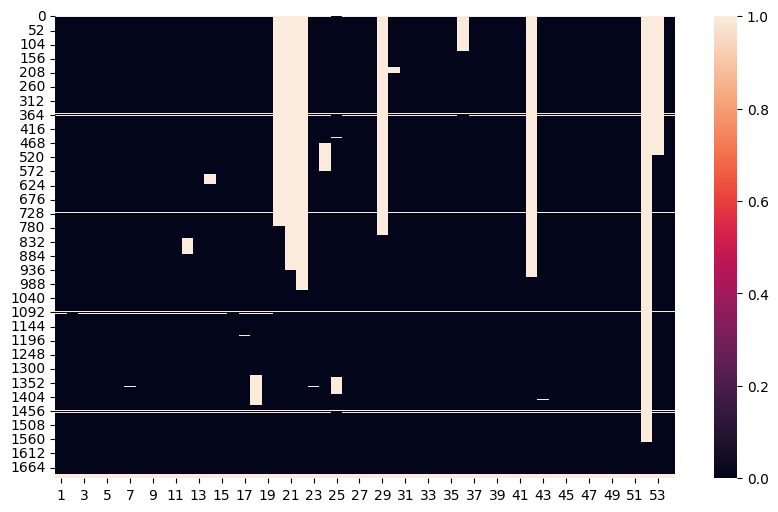

In [51]:
# plt.figure(figsize=(10,6))
# sns.heatmap(df_transactions_pivot[list(range(1, 55))].isna())

In [32]:
df_train = pd.read_csv(os.path.join(file_path, 'train.csv'))

df_train.head(5)

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [33]:
df_train.drop('id', axis=1, inplace=True)

df_train.head()

date  store_nbr      family  sales  onpromotion
0  2013-01-01          1  AUTOMOTIVE    0.0            0
1  2013-01-01          1   BABY CARE    0.0            0
2  2013-01-01          1      BEAUTY    0.0            0
3  2013-01-01          1   BEVERAGES    0.0            0
4  2013-01-01          1       BOOKS    0.0            0

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 114.5+ MB


In [35]:
family_types = list(df_train['family'].unique())

len(family_types)

33

In [36]:
df_train['family'] = df_train['family'].apply(lambda family: family_types.index(family))

df_train.head(5)

date  store_nbr  family  sales  onpromotion
0  2013-01-01          1       0    0.0            0
1  2013-01-01          1       1    0.0            0
2  2013-01-01          1       2    0.0            0
3  2013-01-01          1       3    0.0            0
4  2013-01-01          1       4    0.0            0

In [37]:
df_train_store = df_store.copy()

df_train_store.head(5)

store_nbr           city type  cluster
0          1          Quito    D       13
1          2          Quito    D       13
2          3          Quito    D        8
3          4          Quito    D        9
4          5  Santo Domingo    D        4

In [38]:
cities = list(df_train_store['city'].unique())
df_train_store['city'] = df_train_store['city'].apply(lambda city: cities.index(city))

df_train_store.head(5)

store_nbr  city type  cluster
0          1     0    D       13
1          2     0    D       13
2          3     0    D        8
3          4     0    D        9
4          5     1    D        4

In [39]:
types = list(df_train_store['type'].unique())
types.sort()
df_train_store['type'] = df_train_store['type'].apply(lambda store_type: types.index(store_type))

df_train_store.head(5)

store_nbr  city  type  cluster
0          1     0     3       13
1          2     0     3       13
2          3     0     3        8
3          4     0     3        9
4          5     1     3        4

In [40]:
df_train_store['transactions'] = df_train_store['store_nbr'].apply(lambda id: df_transactions[df_transactions['store_nbr'] == id]['transactions'].mean())

df_train_store.head(5)

store_nbr  city  type  cluster  transactions
0          1     0     3       13   1523.844272
1          2     0     3       13   1920.036374
2          3     0     3        8   3201.879475
3          4     0     3        9   1502.987470
4          5     1     3        4   1400.045915

In [41]:
df_train_store['sales'] = df_train_store['store_nbr'].apply(lambda id: df_train[df_train['store_nbr'] == id]['sales'].mean())

df_train_store.head(5)

store_nbr  city  type  cluster  transactions       sales
0          1     0     3       13   1523.844272  254.534889
1          2     0     3       13   1920.036374  387.918172
2          3     0     3        8   3201.879475  908.405495
3          4     0     3        9   1502.987470  340.273886
4          5     1     3        4   1400.045915  280.580231

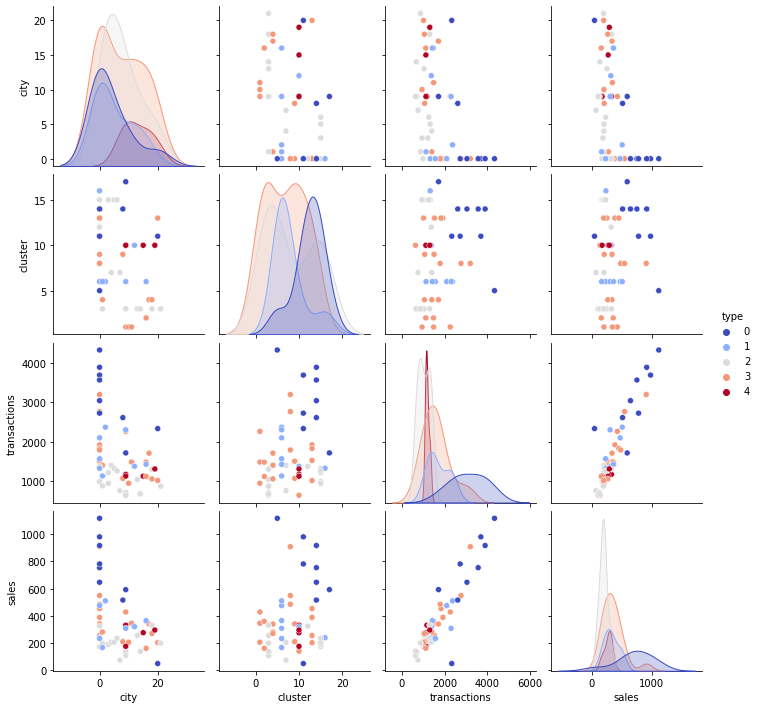

In [42]:
sns.pairplot(df_train_store[['city', 'type', 'cluster', 'transactions', 'sales']], hue='type', palette='coolwarm')

In [43]:
df_train_date = pd.DataFrame(df_train['date'].unique(), columns=['date'])

df_train_date.head(5)

date
0  2013-01-01
1  2013-01-02
2  2013-01-03
3  2013-01-04
4  2013-01-05

In [44]:
df_train_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1684 non-null   object
dtypes: object(1)
memory usage: 13.3+ KB


In [45]:
df_train_date.loc[len(df_train_date.index) - 1]

date    2017-08-15
Name: 1683, dtype: object

In [ ]:
# df_train_date['oil_price'] = df_train_date['date'].apply(lambda date: df_oil[df_oil['date'] == date]['dcoilwtico'].values[0])

# df_train_date.head(5)

In [ ]:
# def is_celebrated(date):
#   if df_holiday[df_holiday['date'] == date]['celebrate'].size == 0:
#     return False
#   elif df_holiday[df_holiday['date'] == date]['celebrate'].values[0] == False:
#     return False
#   else:
#     return True

# df_train_date['celebrate'] = df_train_date['date'].apply(lambda date: is_celebrated(date))

# df_train_date.head(5)

In [ ]:
# df_train_date.info()

In [ ]:
# df_train_date['transactions'] = df_train_date['date'].apply(lambda date: df_transactions[df_transactions['date'] == date]['transactions'].mean())

# df_train_date.head(5)

In [ ]:
# df_train_date['sales'] = df_train_date['date'].apply(lambda date: df_train[df_train['date'] == date]['sales'].mean())

# df_train_date.head(5)

In [ ]:
# df_train_date['onpromotion'] = df_train_date['date'].apply(lambda date: df_train[df_train['date'] == date]['onpromotion'].mean())

# df_train_date.head(5)

In [46]:
# df_train_date.to_csv(os.path.join(file_path, 'train_date.csv'), index=False)

df_train_date = pd.read_csv(os.path.join(file_path, 'train_date.csv'))
df_train_date.head(5)

date  oil_price  celebrate  transactions       sales  onpromotion
0  2013-01-01  94.756667       True    770.000000    1.409438          0.0
1  2013-01-02  93.140000      False   2026.413043  278.390807          0.0
2  2013-01-03  92.970000      False   1706.608696  202.840197          0.0
3  2013-01-04  93.120000      False   1706.391304  198.911154          0.0
4  2013-01-05  94.756667      False   2034.195652  267.873244          0.0

In [47]:
df_train_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1684 non-null   object 
 1   oil_price     1684 non-null   float64
 2   celebrate     1684 non-null   bool   
 3   transactions  1682 non-null   float64
 4   sales         1684 non-null   float64
 5   onpromotion   1684 non-null   float64
dtypes: bool(1), float64(4), object(1)
memory usage: 67.6+ KB


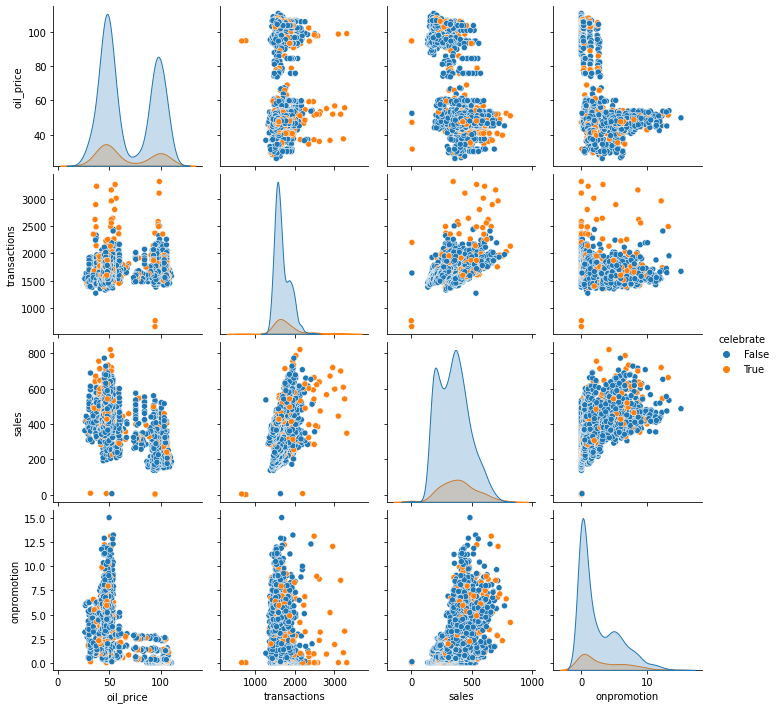

In [48]:
sns.pairplot(df_train_date, hue='celebrate', vars=['oil_price', 'transactions', 'sales', 'onpromotion'])

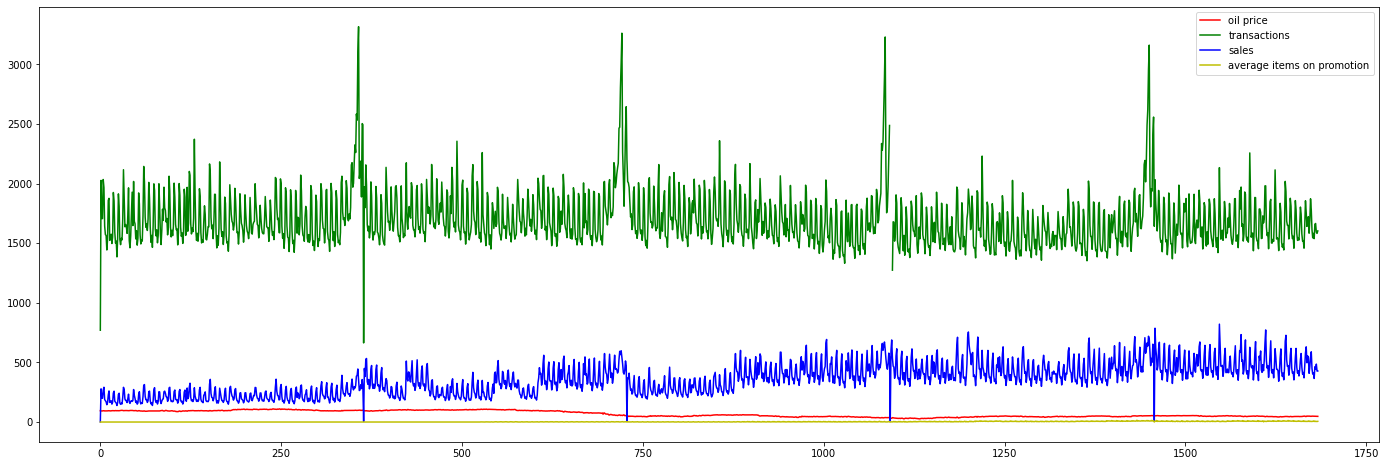

In [49]:
ax = plt.figure(figsize=(24, 8))
x = np.array(df_train_date.index)
plt.plot(x, np.array(df_train_date['oil_price'].values), color='r', label='oil price')
plt.plot(x, np.array(df_train_date['transactions'].values), color='g', label='transactions')
plt.plot(x, np.array(df_train_date['sales'].values), color='b', label='sales')
plt.plot(x, np.array(df_train_date['onpromotion'].values), color='y', label='average items on promotion')
plt.legend()